# Базовое решение

## Чтение данных

In [49]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, Normalizer
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgbse.metrics import concordance_index, approx_brier_score
from xgbse._kaplan_neighbors import DEFAULT_PARAMS
import optuna
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import json

pd.set_option('display.max_rows', None)

In [50]:
accepted = pd.read_csv('lending_data/accepted_base_features.csv')
accepted.head().transpose()

,0,1,2,3,4
loan_amnt,3600.0,24700.0,10400.0,20000.0,20000.0
installment,123.03,820.28,289.91,637.58,631.26
sub_grade,14,11,26,7,6
emp_length,10,10,3,10,10
home_ownership,1,1,1,1,1
annual_inc,55000.0,65000.0,104433.0,180000.0,85000.0
verification_status,0,0,1,0,0
issue_d,42337,42337,42337,42337,42337
purpose,2,11,6,2,6
addr_state,38,41,38,23,40


## Выделение подвыборки для увеличения скорости обучения

In [51]:
accepted = accepted.sample(n=10000)

## Разделение выборки на тренировочную, валидационную и тестовую

In [52]:
X = accepted.drop(columns = ['duration', 'baseline_event'])
y = convert_to_structured(accepted['duration'], accepted['baseline_event'])

In [53]:
X.head()

,loan_amnt,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,purpose,addr_state,...,has_been_recent_bc_dlq,has_been_last_record,fico_range_mean,issue_d_year,issue_d_month,earliest_cr_line_year,earliest_cr_line_month,last_credit_pull_d_year,last_credit_pull_d_month,issue_d_season
249651,30000.0,956.37,7,8,1,178293.0,1,42034,1,32,...,1,1,667.0,2015,2,1988,11,2018,8,1
743851,35000.0,880.61,17,0,5,130000.0,1,41607,2,45,...,1,1,702.0,2013,12,1997,8,2016,10,4
797783,6500.0,203.39,4,8,1,48328.0,0,41454,2,22,...,1,1,742.0,2013,7,1995,4,2018,11,3
173728,11900.0,429.38,20,5,5,35000.0,1,42154,6,34,...,1,1,677.0,2015,6,2011,3,2018,6,2
140943,13000.0,440.10,13,9,4,39728.0,0,42184,2,38,...,1,1,727.0,2015,7,2003,8,2019,3,3


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

## Добавим трансформацию колонок для обучения модели

In [55]:
ohe_cols = ['home_ownership', 
            'purpose', 
            'initial_list_status',
            'disbursement_method',
            'has_been_last_delinq',
            'has_been_recent_revol_delinq',
            'has_been_last_major_derog',
            'has_been_recent_bc_dlq',
            'has_been_last_record',
            'verification_status', 
            'addr_state']

numeric_cols = ['acc_now_delinq',
                 'acc_open_past_24mths',
                 'annual_inc',
                 'avg_cur_bal',
                 'bc_open_to_buy',
                 'bc_util',
                 'chargeoff_within_12_mths',
                 'collections_12_mths_ex_med',
                 'delinq_2yrs',
                 'delinq_amnt',
                 'dti',
                 'earliest_cr_line',
                 'emp_length',
                 'fico_range_high',
                 'fico_range_low',
                 'inq_last_6mths',
                 'installment',
                 'issue_d',
                 'last_credit_pull_d',
                 'loan_amnt',
                 'mo_sin_old_il_acct',
                 'mo_sin_old_rev_tl_op',
                 'mo_sin_rcnt_rev_tl_op',
                 'mo_sin_rcnt_tl',
                 'mort_acc',
                 'mths_since_recent_bc',
                 'mths_since_recent_inq',
                 'num_accts_ever_120_pd',
                 'num_actv_bc_tl',
                 'num_actv_rev_tl',
                 'num_bc_sats',
                 'num_bc_tl',
                 'num_il_tl',
                 'num_op_rev_tl',
                 'num_rev_accts',
                 'num_rev_tl_bal_gt_0',
                 'num_sats',
                 'num_tl_120dpd_2m',
                 'num_tl_30dpd',
                 'num_tl_90g_dpd_24m',
                 'num_tl_op_past_12m',
                 'open_acc',
                 'pct_tl_nvr_dlq',
                 'percent_bc_gt_75',
                 'pub_rec',
                 'pub_rec_bankruptcies',
                 'sub_grade',
                 'tax_liens',
                 'tot_coll_amt',
                 'tot_cur_bal',
                 'tot_hi_cred_lim',
                 'total_acc',
                 'total_bal_ex_mort',
                 'total_bc_limit',
                 'total_il_high_credit_limit',
                 'total_rev_hi_lim']

col_transformer = ColumnTransformer([('ohe_transformer', OneHotEncoder(handle_unknown='infrequent_if_exist'), ohe_cols),
                                    ('norm', Normalizer(), numeric_cols)],
                                    remainder='passthrough')

X_train = col_transformer.fit_transform(X_train)
X_val = col_transformer.transform(X_val)
X_test = col_transformer.transform(X_test)

In [56]:
dtrain = convert_data_to_xgb_format(X_train, y_train, 'survival:aft')
dval = convert_data_to_xgb_format(X_val, y_val, 'survival:aft')
dtest = convert_data_to_xgb_format(X_test, y_test, 'survival:aft')

## Обучим модель

In [57]:
PARAMS_XGB_AFT = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'hist',
    'learning_rate': 5e-2,
    'max_depth': 8,
    'booster': 'dart',
    'subsample': 0.5,
    'min_child_weight': 50,
    'colsample_bynode': 0.5,
    # 'tree_method': 'gpu_hist'
}


bst = xgb.train(
    PARAMS_XGB_AFT,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dval, 'val')],
    verbose_eval=0
)

# predicting and evaluating
preds = bst.predict(dtest)
cind = concordance_index(y_test, -preds, risk_strategy='precomputed')

print(f"C-index: {cind}")
print(f"Average survival time: {preds.mean():.0f} months")

C-index: 0.8421825760338199
Average survival time: 173 months


Text(0, 0.5, 'Вероятность')

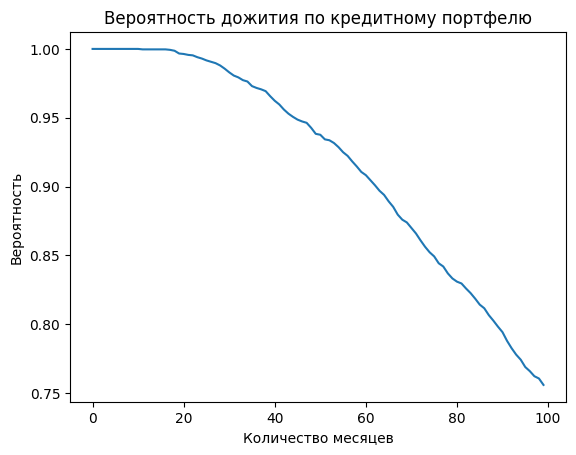

In [60]:
steps = [i for i in range(0, 100)]
vals = [np.count_nonzero(preds > i) for i in steps]
vals = [i / len(preds) for i in vals]

plt.plot(steps, vals)
plt.title('Вероятность дожития по кредитному портфелю')
plt.xlabel('Количество месяцев')
plt.ylabel('Вероятность')


In [61]:
data = {'x': steps, 'y': vals}
with open('./tmp/base_data.json', 'w+') as file:
    json.dump(data, file)